# CheckSpeqGNN 解析ノートブック

このノートブックは、`run_check_Speq_GNN.py` によって生成されたHDF5ファイルを読み込み、
GNNのノード特徴量、誤差、グラフ構造を解析・可視化するためのサンプルコードを提供します。

**必要なライブラリ:**
- h5py
- numpy
- pandas (データフレーム操作用)
- matplotlib (可視化用)
- seaborn (可視化用)
- scikit-learn (PCA, t-SNE用 - オプション)
- networkx (グラフ解析用 - オプション)

```bash
pip install h5py numpy pandas matplotlib seaborn scikit-learn networkx
```

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from numba.misc.appdirs import system
from sklearn.decomposition import PCA
# from sklearn.manifold import t_sne # 必要に応じて
import networkx as nx # 必要に応じて
import random
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr # ピアソンの相関係数計算用
import h5py # HDF5ファイル読み込み用
from tqdm import tqdm # 進捗表示用
from collections import Counter # 前のセルからの結果利用


## 1. HDF5ファイルの読み込みとデータの確認
まず、解析対象のHDF5ファイルを開き、その構造を確認します。
各音声ファイル（例: `p232_001.wav` など）がグループとして保存されており、
その中に `noisy_node`, `clean_node`, `error_node`, `noisy_index`, `clean_index`
というデータセットが含まれています

In [37]:
# ----- 設定項目 -----
# ★ 生成されたHDF5ファイルのパスを指定してください
HDF5_FILE_PATH = '/Users/a/Desktop/SpeqGAT_noise_reverb_analysis_results.h5'
# --------------------
# ★ モデルのSTFTパラメータ (run_check_Speq_GNN.py で使用したもの)
N_FFT = 512
HOP_LENGTH = 256
WIN_LENGTH = 512

# ★ U-Netのダウンサンプリング回数 (CheckSpeqGNNのDown層の数)
NUM_DOWNSAMPLING_LAYERS = 3
# --------------------

try:
    hdf5_file = h5py.File(HDF5_FILE_PATH, 'r')
    print(f"✅ HDF5ファイル '{HDF5_FILE_PATH}' を読み込みました。")
except FileNotFoundError:
    print(f"❌ エラー: ファイルが見つかりません: {HDF5_FILE_PATH}")
    # このセル以降を実行しないようにエラーを発生させるか、デフォルトデータをロードする処理を追加
    raise
except Exception as e:
    print(f"❌ ファイル読み込み中にエラーが発生しました: {e}")
    raise

✅ HDF5ファイル '/Users/a/Desktop/SpeqGAT_noise_reverb_analysis_results.h5' を読み込みました。


### ファイル構造の確認
HDF5ファイル内のグループ（音声ファイル名）とデータセットを確認します。

In [21]:
print("ファイル内のグループ (音声ファイル名):")
file_keys = list(hdf5_file.keys())
print(f"  総ファイル数: {len(file_keys)}")
print(f"  最初の5件: {file_keys[:5]}")

# 最初のファイルのデータセット構造を確認
if file_keys:
    first_file_key = file_keys[0]
    print(f"\n最初のファイル '{first_file_key}' 内のデータセット:")
    print(list(hdf5_file[first_file_key].keys()))
else:
    print("\n⚠️ ファイル内にデータが見つかりませんでした。")

ファイル内のグループ (音声ファイル名):
  総ファイル数: 549
  最初の5件: ['p232_001_TCAR_01ch_12db_760msec_None', 'p232_003_PCAFETER_01ch_-4db_630msec_None', 'p232_006_PRESTO_01ch_12db_320msec_None', 'p232_007_NPARK_01ch_1db_510msec_None', 'p232_010_DKITCHEN_01ch_15db_800msec_None']

最初のファイル 'p232_001_TCAR_01ch_12db_760msec_None' 内のデータセット:
['clean_index', 'clean_node', 'error_node', 'noisy_index', 'noisy_node']


### 特定のファイルからデータを読み込む関数

In [22]:
def load_data_from_hdf5(h5_file, file_key):
    """指定されたキー (ファイル名) のデータをHDF5ファイルから読み込む"""
    if file_key not in h5_file:
        print(f"⚠️ キー '{file_key}' がファイル内に存在しません。")
        return None

    group = h5_file[file_key]
    data = {
        'noisy_node': group['noisy_node'][:],
        'clean_node': group['clean_node'][:],
        'error_node': group['error_node'][:],
        'noisy_index': group['noisy_index'][:],
        'clean_index': group['clean_index'][:]
    }
    return data

# 例: 最初のファイルのデータを読み込む
if file_keys:
    sample_file_key = random.choice(file_keys) # ランダムにファイルを選択
    print(f"\n--- サンプルファイル '{sample_file_key}' のデータを読み込み ---")
    sample_data = load_data_from_hdf5(hdf5_file, sample_file_key)

    if sample_data:
        for key, value in sample_data.items():
            print(f"  {key}: shape={value.shape}, dtype={value.dtype}")


--- サンプルファイル 'p257_422_NFIELD_01ch_2db_750msec_None' のデータを読み込み ---
  noisy_node: shape=(768, 512), dtype=float32
  clean_node: shape=(768, 512), dtype=float32
  error_node: shape=(768, 512), dtype=float32
  noisy_index: shape=(49152, 2), dtype=int64
  clean_index: shape=(49152, 2), dtype=int64


## 2. ノード特徴量の解析

特定の音声ファイルについて、ノイズあり (`noisy_node`) とクリーン (`clean_node`) のノード特徴量、およびその差分 (`error_node`) を比較します。

In [23]:
if sample_data:
    noisy_node_feat = sample_data['noisy_node']
    clean_node_feat = sample_data['clean_node']
    error_node_feat = sample_data['error_node']

    # ノード数は特徴量配列の最初の次元
    num_nodes = noisy_node_feat.shape[0]
    # 特徴量次元は2番目の次元
    feature_dim = noisy_node_feat.shape[1]
    print(f"\nサンプルファイル '{sample_file_key}':")
    print(f"  ノード数 (F*T in bottleneck): {num_nodes}")
    print(f"  特徴量次元 (Channels in bottleneck): {feature_dim}")


サンプルファイル 'p257_422_NFIELD_01ch_2db_750msec_None':
  ノード数 (F*T in bottleneck): 768
  特徴量次元 (Channels in bottleneck): 512


### 2.1. 基本統計量の比較
ノイズあり、クリーン、誤差の特徴量の平均値と標準偏差を比較します。

In [24]:
if sample_data:
    stats = {
        'Noisy': {'Mean': np.mean(noisy_node_feat), 'Std': np.std(noisy_node_feat)},
        'Clean': {'Mean': np.mean(clean_node_feat), 'Std': np.std(clean_node_feat)},
        'Error': {'Mean': np.mean(error_node_feat), 'Std': np.std(error_node_feat)}
    }

    stats_df = pd.DataFrame(stats).T # 転置して見やすくする
    print("\nノード特徴量の基本統計量:")
    print(stats_df)

    # 誤差の絶対値の平均も確認
    print(f"\n誤差の絶対値の平均: {np.mean(np.abs(error_node_feat)):.4f}")




ノード特徴量の基本統計量:
           Mean       Std
Noisy  0.005024  0.497653
Clean -0.016858  0.806402
Error -0.021882  0.861497

誤差の絶対値の平均: 0.4748


### 2.2. 特徴量分布の可視化 (例: ヒストグラム)
各特徴量セットの分布をヒストグラムで比較します。

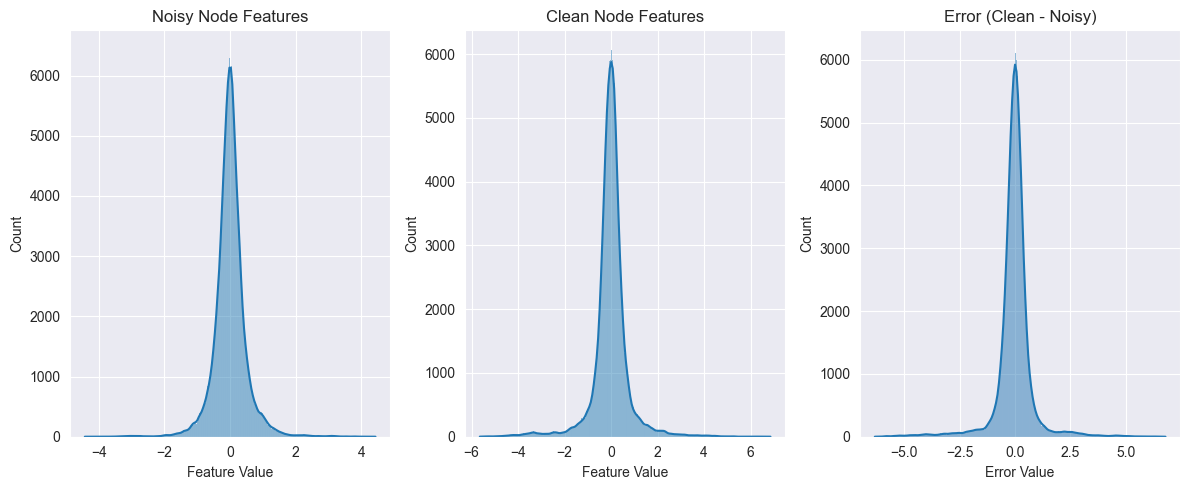

In [25]:
if sample_data:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    sns.histplot(noisy_node_feat.flatten(), kde=True)
    plt.title('Noisy Node Features')
    plt.xlabel('Feature Value')

    plt.subplot(1, 3, 2)
    sns.histplot(clean_node_feat.flatten(), kde=True)
    plt.title('Clean Node Features')
    plt.xlabel('Feature Value')

    plt.subplot(1, 3, 3)
    sns.histplot(error_node_feat.flatten(), kde=True)
    plt.title('Error (Clean - Noisy)')
    plt.xlabel('Error Value')

    plt.tight_layout()
    plt.show()

### (オプション) 2.3. 次元削減による可視化 (PCA)
PCAを使ってノード特徴量を2次元に削減し、ノイズありとクリーンで分布を比較します。
(ノード数が多い場合、計算に時間がかかることがあります)


PCAによる次元削減を実行中...
PCA完了。


/opt/anaconda3/envs/GNN/lib/python3.11/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/anaconda3/envs/GNN/lib/python3.11/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/anaconda3/envs/GNN/lib/python3.11/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/anaconda3/envs/GNN/lib/python3.11/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/anaconda3/envs/GNN/lib/python3.11/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/anaconda3/envs/GNN/lib/python3.11/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/anaconda3/envs/GNN/lib/py

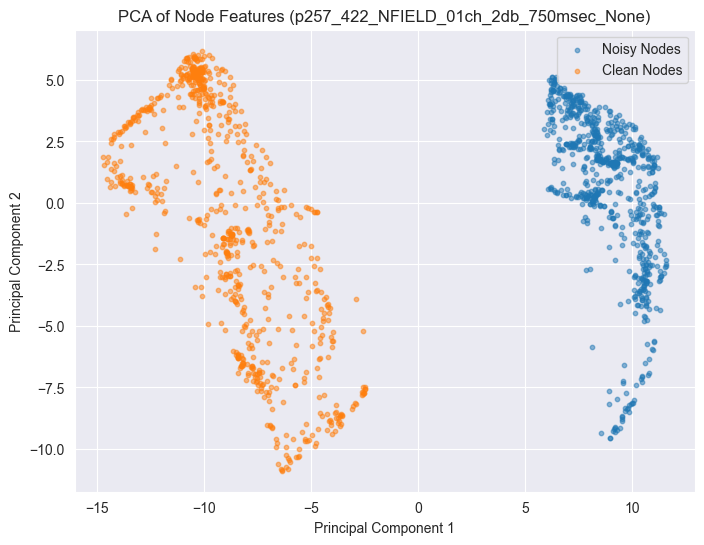

In [26]:
if sample_data and num_nodes < 50000: # ノード数が多すぎるとメモリや時間がかかるため制限
    print("\nPCAによる次元削減を実行中...")
    pca = PCA(n_components=2)

    # ノイズありとクリーンを結合してPCAを適用
    combined_features = np.vstack((noisy_node_feat, clean_node_feat))
    pca.fit(combined_features)

    # 各々を2次元に変換
    noisy_pca = pca.transform(noisy_node_feat)
    clean_pca = pca.transform(clean_node_feat)

    print("PCA完了。")

    # 可視化
    plt.figure(figsize=(8, 6))
    plt.scatter(noisy_pca[:, 0], noisy_pca[:, 1], alpha=0.5, label='Noisy Nodes', s=10)
    plt.scatter(clean_pca[:, 0], clean_pca[:, 1], alpha=0.5, label='Clean Nodes', s=10)
    plt.title(f'PCA of Node Features ({sample_file_key})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("\n(オプション) PCA可視化はスキップされました (ノード数が多すぎる可能性があります)。")


## 3. グラフ構造の解析

特定の音声ファイルについて、ノイズあり (`noisy_index`) とクリーン (`clean_index`) のグラフ構造を比較します。エッジ情報は `[送信元ノード, 受信先ノード]` の形式で保存されています。


In [27]:
if sample_data:
    noisy_edges = sample_data['noisy_index']
    clean_edges = sample_data['clean_index']

    print(f"\nグラフエッジ情報 ({sample_file_key}):")
    print(f"  Noisyグラフのエッジ数: {noisy_edges.shape[0]}")
    print(f"  Cleanグラフのエッジ数: {clean_edges.shape[0]}")

    # エッジ数は num_nodes * k (kはKNNの近傍数) に近いはず



グラフエッジ情報 (p257_422_NFIELD_01ch_2db_750msec_None):
  Noisyグラフのエッジ数: 49152
  Cleanグラフのエッジ数: 49152


### 3.1. 共通エッジの割合
ノイズありグラフとクリーングラフで共通して存在するエッジの割合を計算します。

In [28]:
if sample_data:
    # エッジをタプルのセットに変換して比較しやすくする
    noisy_edge_set = set(map(tuple, noisy_edges))
    clean_edge_set = set(map(tuple, clean_edges))

    common_edges = noisy_edge_set.intersection(clean_edge_set)

    total_possible_edges = len(noisy_edge_set) + len(clean_edge_set) - len(common_edges) # 和集合のサイズ

    if total_possible_edges > 0:
      common_ratio = len(common_edges) / total_possible_edges
    else:
      common_ratio = 0.0

    print(f"\n共通エッジの割合 ({sample_file_key}):")
    print(f"  Noisyエッジ数: {len(noisy_edge_set)}")
    print(f"  Cleanエッジ数: {len(clean_edge_set)}")
    print(f"  共通エッジ数: {len(common_edges)}")
    print(f"  共通エッジの割合: {common_ratio:.4f}")



共通エッジの割合 (p257_422_NFIELD_01ch_2db_750msec_None):
  Noisyエッジ数: 32662
  Cleanエッジ数: 32878
  共通エッジ数: 17756
  共通エッジの割合: 0.3716


### (オプション) 3.2. 次数分布の比較
各ノードの接続数（次数）の分布を比較します。`networkx`ライブラリが必要です。



次数分布を計算中...
次数分布計算完了。


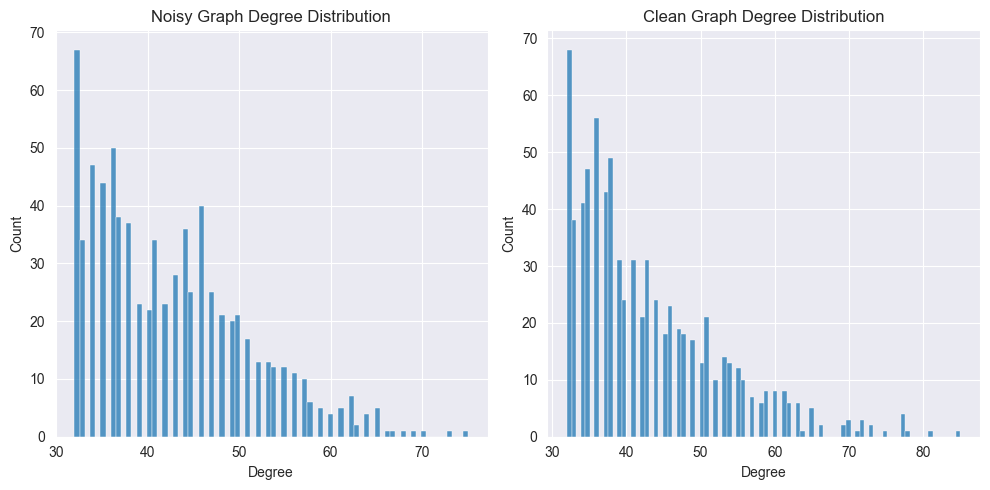


次数統計:
  Noisy - Mean: 42.53, Max: 75, Min: 32
  Clean - Mean: 42.81, Max: 85, Min: 32


In [34]:
# if sample_data and 'nx' in sys.modules:
def get_degree_distribution(num_nodes, edges):
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    G.add_edges_from(edges)
    degrees = [G.degree(n) for n in G.nodes()]
    return degrees

print("\n次数分布を計算中...")
noisy_degrees = get_degree_distribution(num_nodes, noisy_edges)
clean_degrees = get_degree_distribution(num_nodes, clean_edges)
print("次数分布計算完了。")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.histplot(noisy_degrees, kde=False, bins=max(noisy_degrees) + 1)
plt.title('Noisy Graph Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(clean_degrees, kde=False, bins=max(clean_degrees) + 1)
plt.title('Clean Graph Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

print("\n次数統計:")
print(f"  Noisy - Mean: {np.mean(noisy_degrees):.2f}, Max: {np.max(noisy_degrees)}, Min: {np.min(noisy_degrees)}")
print(f"  Clean - Mean: {np.mean(clean_degrees):.2f}, Max: {np.max(clean_degrees)}, Min: {np.min(clean_degrees)}")

# else:
#     print("\n(オプション) 次数分布の計算はスキップされました (networkxが見つからないか、データがありません)。")


## 4. 誤差とグラフ構造の関係 (探索的分析例)

`error_node` が大きい（ノイズの影響が大きい）ノードが、グラフ内でどのような接続特性を持つかを見てみます。

In [35]:
if sample_data and 'nx' in sys.modules and 'noisy_degrees' in locals():
    # 誤差の絶対値が大きい上位N%のノードを取得
    error_abs = np.abs(error_node_feat).mean(axis=1) # 各ノードの特徴量次元方向の平均誤差
    threshold = np.percentile(error_abs, 95) # 上位5%の閾値
    high_error_nodes = np.where(error_abs >= threshold)[0]

    print(f"\n誤差が大きい上位5%のノード数: {len(high_error_nodes)}")

    if len(high_error_nodes) > 0:
        # 誤差が大きいノードの次数（Noisyグラフ）
        degrees_of_high_error_nodes_noisy = [noisy_degrees[i] for i in high_error_nodes if i < len(noisy_degrees)]

        # 誤差が大きいノードの次数（Cleanグラフ）
        degrees_of_high_error_nodes_clean = [clean_degrees[i] for i in high_error_nodes if i < len(clean_degrees)]

        print("\n誤差が大きいノードの次数統計:")
        if degrees_of_high_error_nodes_noisy:
          print(f"  Noisy Graph - Mean Degree: {np.mean(degrees_of_high_error_nodes_noisy):.2f}")
        if degrees_of_high_error_nodes_clean:
          print(f"  Clean Graph - Mean Degree: {np.mean(degrees_of_high_error_nodes_clean):.2f}")

        # 全ノードの平均次数と比較
        print(f"  (参考) 全ノードの平均次数 - Noisy: {np.mean(noisy_degrees):.2f}, Clean: {np.mean(clean_degrees):.2f}")

## 5. ノード誤差のヒートマップ可視化 🗺️

ノード間の誤差 (`error_node`) を特徴量次元で平均し、元のスペクトログラムに対応する空間的な形状 `[h, w]` に戻してヒートマップとして可視化します。
これにより、どの時間・周波数領域でノイズの影響が大きい（特徴量の変化が大きい）かを視覚的に把握できます。



ボトルネック特徴マップの推定形状: h=32, w=24 (Total=768)


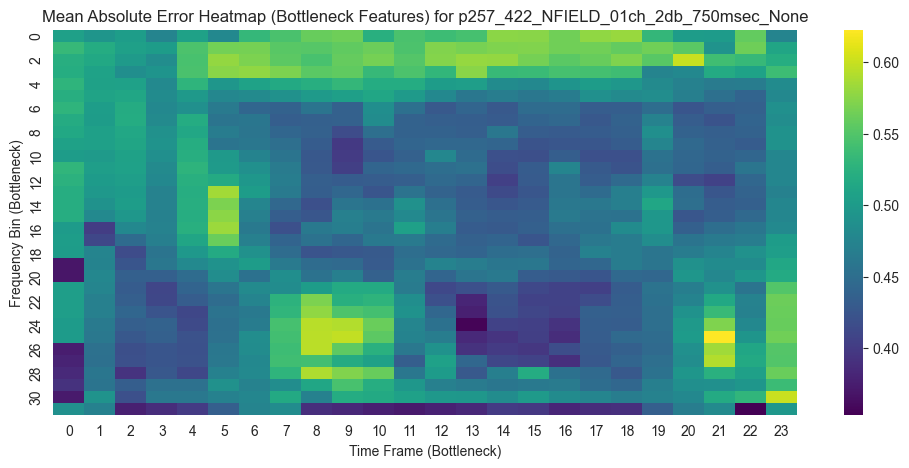

In [39]:
if sample_data:
    # 1. 誤差の絶対値を取得し、特徴量次元で平均
    mean_abs_error_per_node = np.mean(np.abs(error_node_feat), axis=1) # [num_nodes]

    # 2. ボトルネック特徴マップの h と w を計算
    #    元の周波数ビン数 F = N_FFT / 2 + 1
    #    ダウンサンプリング係数 factor = 2 ** NUM_DOWNSAMPLING_LAYERS
    #    h = floor(F / factor)
    #    w は num_nodes / h から算出
    F = N_FFT // 2 + 1
    downsampling_factor = 2 ** NUM_DOWNSAMPLING_LAYERS
    # CheckSpeqGNNのDownレイヤは単純なMaxPool2d(2)なのでfloorでOK
    h_bottleneck = F
    for _ in range(NUM_DOWNSAMPLING_LAYERS):
        h_bottleneck = math.floor(h_bottleneck / 2)

    if num_nodes % h_bottleneck != 0:
        print(f"⚠️ 警告: ノード数 {num_nodes} が計算されたh={h_bottleneck}で割り切れません。形状の推定が不正確な可能性があります。")
        # ここで処理を中断するか、近似値を使うか選択
        # 近似値を使う場合:
        w_bottleneck = math.ceil(num_nodes / h_bottleneck)
        # 必要に応じて mean_abs_error_per_node をリサイズ/パディング
        expected_nodes = h_bottleneck * w_bottleneck
        if num_nodes < expected_nodes:
            mean_abs_error_per_node = np.pad(mean_abs_error_per_node, (0, expected_nodes - num_nodes))
        elif num_nodes > expected_nodes:
             mean_abs_error_per_node = mean_abs_error_per_node[:expected_nodes]
        print(f"   w={w_bottleneck}と推定し、ノード数を{expected_nodes}に調整しました。")
    else:
        w_bottleneck = num_nodes // h_bottleneck
        expected_nodes = num_nodes

    print(f"\nボトルネック特徴マップの推定形状: h={h_bottleneck}, w={w_bottleneck} (Total={expected_nodes})")

    # 3. 平均誤差ベクトルを [h, w] にリシェイプ
    #    flatten時の操作 (view -> permute -> reshape) を考慮すると、
    #    reshape(h, w) で周波数(h)が速く変化し、時間(w)が遅く変化する C-order になっているはず。
    try:
        error_heatmap = mean_abs_error_per_node.reshape(h_bottleneck, w_bottleneck)
    except ValueError as e:
        print(f"❌ エラー: 推定された形状 (h={h_bottleneck}, w={w_bottleneck}) へのリシェイプに失敗しました: {e}")
        error_heatmap = None # エラー発生時はヒートマップを None に

    # 4. ヒートマップの表示
    if error_heatmap is not None:
        plt.figure(figsize=(12, 5))
        sns.heatmap(error_heatmap, cmap='viridis') # viridisカラーマップを使用
        plt.title(f'Mean Absolute Error Heatmap (Bottleneck Features) for {sample_file_key}')
        plt.xlabel('Time Frame (Bottleneck)')
        plt.ylabel('Frequency Bin (Bottleneck)')
        # y軸のインデックスを反転させて低周波数を下にする（任意）
        # plt.gca().invert_yaxis()
        plt.show()

 ## 6. エッジ接続回数 (入次数) の分析

全ての音声ファイルにわたって、各ノードがエッジの**接続先**として選ばれた回数（入次数）を集計します。
これにより、グラフ内で特に情報が集約されやすい、あるいは重要視されるノード（時間・周波数ビン）を特定できる可能性があります。
`noisy_index` と `clean_index` の両方から集計します。

In [43]:
# 前のセルで hdf5_file と file_keys が定義されていることを確認
if 'hdf5_file' in locals() and hdf5_file and 'file_keys' in locals() and file_keys:
    print("全ファイルのグラフ構造からエッジ接続回数（入次数）を集計中...")

    # 各ノードIDが接続先として出現した回数をカウントするための Counter オブジェクト
    node_in_degree_counter = Counter()
    total_edges = 0 # 全エッジ数を記録する変数
    max_node_index = -1 # 全体で最大のノードインデックスを追跡（データセットのサイズ確認用）

    # HDF5ファイル内の各ファイル（グループ）をループ処理
    for file_key in tqdm(file_keys, desc="ファイル処理中"):
        data = load_data_from_hdf5(hdf5_file, file_key) # 前のセルで定義した関数を使用
        if data:
            # noisy_index と clean_index からターゲットノード（エッジの終点、2列目 [:, 1]）を抽出
            noisy_targets = data['noisy_index'][:, 1]
            clean_targets = data['clean_index'][:, 1]

            # Counter を使って、各ターゲットノードの出現回数を更新
            node_in_degree_counter.update(noisy_targets)
            node_in_degree_counter.update(clean_targets)

            # 処理したエッジの総数を加算
            total_edges += len(noisy_targets) + len(clean_targets)

            # このファイルで見つかった最大のノードインデックスを更新
            current_max = -1
            if len(noisy_targets) > 0:
                current_max = max(current_max, noisy_targets.max())
            if len(clean_targets) > 0:
                 current_max = max(current_max, clean_targets.max())
            max_node_index = max(max_node_index, current_max)


    print(f"集計完了。総エッジ数: {total_edges}, 最大ノードインデックス: {max_node_index}")

    # 集計結果（Counter）が存在し、エッジが1つ以上ある場合
    if node_in_degree_counter and total_edges > 0:
        # most_common(10) メソッドで、カウント数が多い上位10件の (ノードID, カウント数) タプルを取得
        top_10_nodes = node_in_degree_counter.most_common(10)

        # --- ★ 平均値と分散の計算を追加 ---
        all_counts = list(node_in_degree_counter.values()) # 全てのノードのカウント数をリストとして取得
        mean_count = np.mean(all_counts)
        variance_count = np.var(all_counts)
        std_dev_count = np.std(all_counts) # 標準偏差も計算

        # 結果を表形式で表示
        print("\n--- エッジ接続回数（入次数）トップ10 ---")
        print(f"{'ノード番号':<12} {'接続された回数':<15} {'割合 (%)':<15}")
        print("-" * 45)
        for node_index, count in top_10_nodes:
            # 全エッジ数に対する割合を計算
            percentage = (count / total_edges) * 100
            # 各項目を整形して表示
            print(f"{node_index:<12} {count:<15} {percentage:>14.4f}%")
        print("-" * 45)

        # --- ★ 平均値と分散の表示を追加 ---
        print("\n--- 全ノードの接続回数（入次数）統計 ---")
        print(f"  平均接続回数: {mean_count:.4f}")
        print(f"  接続回数の分散: {variance_count:.4f}")
        print(f"  接続回数の標準偏差: {std_dev_count:.4f}")
        print("-" * 45)

    elif total_edges == 0:
        print("\n⚠️ エッジが見つからなかったため、統計情報は計算できません。グラフ設定を確認してください。")
    else:
        print("\n⚠️ 集計結果が空です。")

else:
    print("\n⚠️ HDF5ファイルが正しく読み込まれていないか、ファイルキーが存在しないため、エッジ接続回数を分析できません。")

全ファイルのグラフ構造からエッジ接続回数（入次数）を集計中...




ファイル処理中:   0%|          | 0/549 [00:00<?, ?it/s]

ファイル処理中:   1%|▏         | 7/549 [00:00<00:08, 63.97it/s]

ファイル処理中:   3%|▎         | 14/549 [00:00<00:09, 55.37it/s]

ファイル処理中:   5%|▌         | 28/549 [00:00<00:05, 88.24it/s]

ファイル処理中:   7%|▋         | 40/549 [00:00<00:05, 99.34it/s]

ファイル処理中:  10%|█         | 55/549 [00:00<00:04, 113.84it/s]

ファイル処理中:  12%|█▏        | 67/549 [00:00<00:04, 114.40it/s]

ファイル処理中:  14%|█▍        | 79/549 [00:00<00:04, 113.61it/s]

ファイル処理中:  17%|█▋        | 92/549 [00:00<00:03, 116.20it/s]

ファイル処理中:  19%|█▉        | 104/549 [00:00<00:03, 116.62it/s]

ファイル処理中:  21%|██        | 116/549 [00:01<00:03, 112.00it/s]

ファイル処理中:  23%|██▎       | 128/549 [00:01<00:03, 107.85it/s]

ファイル処理中:  26%|██▌       | 141/549 [00:01<00:03, 113.65it/s]

ファイル処理中:  28%|██▊       | 153/549 [00:01<00:03, 113.60it/s]

ファイル処理中:  30%|███       | 165/549 [00:01<00:03, 107.27it/s]

ファイル処理中:  32%|███▏      | 176/549 [00:01<00:03, 105.23it/s]

ファイル処理中:  34%|███▍      | 187/549 [00:01<00:03

集計完了。総エッジ数: 42708992, 最大ノードインデックス: 2431

--- エッジ接続回数（入次数）トップ10 ---
ノード番号        接続された回数         割合 (%)         
---------------------------------------------
291          78396                   0.1836%
327          78150                   0.1830%
333          77743                   0.1820%
283          77534                   0.1815%
282          77506                   0.1815%
317          77393                   0.1812%
243          77210                   0.1808%
309          77002                   0.1803%
302          76936                   0.1801%
318          76897                   0.1800%
---------------------------------------------

--- 全ノードの接続回数（入次数）統計 ---
  平均接続回数: 17561.2632
  接続回数の分散: 709593431.5788
  接続回数の標準偏差: 26638.1950
---------------------------------------------


### 解析のポイント

* **ノード番号**: GNNが処理するボトルネック特徴マップを平坦化した際のインデックス番号です。この番号が具体的にどの時間・周波数ビンに対応するかは、前のセルで計算した `h_bottleneck` と `w_bottleneck` を使って逆算できます（例: `node_index // w_bottleneck` が周波数方向、`node_index % w_bottleneck` が時間方向のインデックス）。
* **接続された回数**: そのノードが、他のノードからの接続先（エッジの終点）として選ばれた合計回数です。これはグラフ理論における**入次数 (In-degree)** に相当します。
* **割合 (%)**: 全てのファイル、全てのノイズあり/なしグラフにおける総エッジ数に対して、そのノードが入次数としてカウントされた割合を示します。
この結果から、特定のノード（特定の時間・周波数領域に対応）がグラフ全体で**情報が集まりやすいハブのような役割**を担っているかどうかが分かります。もし特定のノードに接続が集中している場合、その領域が音声強調において重要であるとモデルが判断している可能性があります。あるいは、その領域のノイズ特性が他の領域と大きく異なり、グラフ構築（例: KNN）に影響を与えている可能性も考えられます。📈

## 7. 誤差とエッジ接続回数（入次数）の相関分析
各ノードについて、特徴量の平均絶対誤差と、そのノードが接続先として選ばれた総回数（入次数）との相関関係を調べます。
これにより、ノイズの影響が大きいノード（誤差が大きいノード）が、グラフ内で他のノードから情報を多く受け取る傾向があるか（入次数が多いか）などを確認できます。

全ファイルの誤差データを集計中...


誤差データ集計中: 100%|██████████| 549/549 [00:00<00:00, 1236.11it/s]
/opt/anaconda3/envs/GNN/lib/python3.11/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/opt/anaconda3/envs/GNN/lib/python3.11/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/opt/anaconda3/envs/GNN/lib/python3.11/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


誤差データの集計完了。

--- 誤差と接続回数（入次数）の相関分析 ---
  対象ノード数: 2432
  ピアソンの相関係数 (r): 0.1067
  p値: 1.316e-07
  相関の強さ: ほとんど相関なし
  統計的に有意な相関が見られます (p < 0.05)。


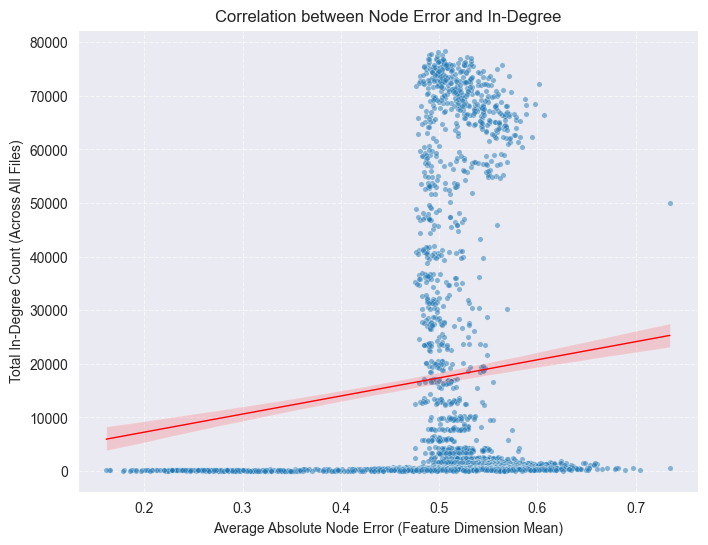

In [51]:
# 前のセルで hdf5_file, file_keys, node_in_degree_counter, max_node_index が
# 計算・定義されていることを前提とします。

# 前提条件のチェック
if 'hdf5_file' not in locals() or not hdf5_file:
    print("❌ エラー: HDF5ファイルが開かれていません。前のセルを再実行してください。")
elif 'file_keys' not in locals() or not file_keys:
    print("❌ エラー: ファイルキーリストが見つかりません。前のセルを再実行してください。")
elif 'node_in_degree_counter' not in locals() or not node_in_degree_counter:
     print("❌ エラー: ノード接続回数 (node_in_degree_counter) が計算されていません。前のセルを再実行してください。")
elif 'max_node_index' not in locals() or max_node_index < 0:
     print("❌ エラー: 最大ノードインデックス (max_node_index) が無効です。前のセルを再実行してください。")
else:
    print("全ファイルの誤差データを集計中...")

    # 各ノードIDごとの誤差の合計値と出現ファイル数を記録する配列を初期化
    # サイズは最大のノードインデックス+1とする
    total_node_error_sum = np.zeros(max_node_index + 1, dtype=float)
    node_occurrence_count = np.zeros(max_node_index + 1, dtype=int)

    # 全ファイルをループして誤差を集計
    for file_key in tqdm(file_keys, desc="誤差データ集計中"):
        data = load_data_from_hdf5(hdf5_file, file_key)
        if data:
            error_node_feat = data['error_node']
            # 各ノードの特徴量次元方向の平均絶対誤差を計算
            mean_abs_error_per_node = np.mean(np.abs(error_node_feat), axis=1)

            # ノードインデックスは 0 から error_node_feat.shape[0] - 1 まで
            node_indices = np.arange(len(mean_abs_error_per_node))

            # 対応するノードインデックスの誤差合計と出現回数を加算
            # NumPyのインデックス参照を使って効率化
            valid_indices = node_indices[node_indices <= max_node_index]
            total_node_error_sum[valid_indices] += mean_abs_error_per_node[valid_indices]
            node_occurrence_count[valid_indices] += 1

    print("誤差データの集計完了。")

    # ----- 集計結果から相関分析用のデータを作成 -----

    # 一度でも出現したノードのインデックスを取得
    valid_nodes_mask = node_occurrence_count > 0
    valid_node_indices = np.where(valid_nodes_mask)[0]

    if len(valid_node_indices) > 0:
        # 平均誤差を計算 (合計誤差 / 出現回数)
        average_node_error = total_node_error_sum[valid_nodes_mask] / node_occurrence_count[valid_nodes_mask]

        # 対応するノードの接続回数（入次数）を取得
        node_degrees = [node_in_degree_counter.get(node_idx, 0) for node_idx in valid_node_indices] # Counterから取得

        # Pandas DataFrameにまとめる
        correlation_df = pd.DataFrame({
            'Node Index': valid_node_indices,
            'Average Abs Error': average_node_error,
            'In-Degree Count': node_degrees
        })

        # --- 相関分析 ---
        # ピアソンの相関係数とp値を計算
        correlation, p_value = pearsonr(correlation_df['Average Abs Error'], correlation_df['In-Degree Count'])

        print("\n--- 誤差と接続回数（入次数）の相関分析 ---")
        print(f"  対象ノード数: {len(correlation_df)}")
        print(f"  ピアソンの相関係数 (r): {correlation:.4f}")
        print(f"  p値: {p_value:.4g}") # .4g は有効数字4桁で表示 (科学的記数法含む)

        # 相関の強さの目安を表示
        if abs(correlation) >= 0.7:
            corr_strength = "強い相関"
        elif abs(correlation) >= 0.4:
            corr_strength = "中程度の相関"
        elif abs(correlation) >= 0.2:
            corr_strength = "弱い相関"
        else:
            corr_strength = "ほとんど相関なし"
        print(f"  相関の強さ: {corr_strength}")
        if p_value < 0.05:
            print("  統計的に有意な相関が見られます (p < 0.05)。")
        else:
            print("  統計的に有意な相関は見られません (p >= 0.05)。")

        # --- 可視化 (散布図) ---
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=correlation_df, x='Average Abs Error', y='In-Degree Count', alpha=0.5, s=15) # sでマーカーサイズ調整
        # 回帰直線を追加 (オプション)
        sns.regplot(data=correlation_df, x='Average Abs Error', y='In-Degree Count', scatter=False, color='red', line_kws={'linewidth':1})

        plt.title('Correlation between Node Error and In-Degree')
        plt.xlabel('Average Absolute Node Error (Feature Dimension Mean)')
        plt.ylabel('Total In-Degree Count (Across All Files)')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

    else:
        print("\n⚠️ 有効なノードデータが見つからなかったため、相関分析を実行できませんでした。")


### 解析のポイント
* **ピアソンの相関係数 (r)**: -1から+1の間の値を取り、誤差と接続回数の直線的な関係の強さを示します。+1に近いほど強い正の相関（誤差が大きいノードほど接続回数が多い）、-1に近いほど強い負の相関（誤差が大きいノードほど接続回数が少ない）、0に近いほど相関が弱いことを意味します。
* **p値**: 計算された相関係数が偶然得られたものである確率を示します。一般的にp値が0.05未満の場合、統計的に有意な相関があると判断されます。
* **散布図**: 各ノードを点としてプロットし、横軸に平均誤差、縦軸に接続回数を取ります。点の分布パターンから、直線的な関係だけでなく、非線形な関係や外れ値の存在などを視覚的に確認できます。赤い線は回帰直線で、全体の傾向を示します。
この分析により、「ノイズの影響を強く受ける（誤差が大きい）ノードは、グラフ内で他のノードからより多くの情報を受け取る傾向があるか？」といった問いに対する答えの手がかりが得られます。🧠🔗


## . まとめと後片付け

これまでの解析で、特定の音声ファイルにおけるノード特徴量とグラフ構造の基本的な比較を行いました。
さらに詳細な分析（例: 特定の時間・周波数領域に対応するノード群の分析、複数ファイルにわたる統計分析など）も可能です。

最後に、開いたHDF5ファイルを閉じます。


In [17]:
if 'hdf5_file' in locals() and hdf5_file:
    hdf5_file.close()
    print("\n✅ HDF5ファイルを閉じました。")


✅ HDF5ファイルを閉じました。
